In [199]:
import os
from collections import namedtuple
from pprint import pprint
import pandas as pd
from tqdm import tqdm
import ipaddress
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [102]:
simulator_data = pd.read_csv("metis_files/switch-stats.csv")
simulator_data = simulator_data.sort_values('SWITCH_ID')
simulator_data['IN'] = simulator_data['IN_TOTAL'] 
simulator_data = simulator_data.drop(columns=['PEID', 'LPID', 'DROP_ROUTE', 'DROP_TTL', 'DROP_OTHER', 'IN_FINAL', 'IN_FORWARD', 'IN_TOTAL'])
simulator_data.head(10)

,SWITCH_ID,GEN,OUT,IN
959,1,2012,2232,4185
2751,2,2011,2231,5206
2311,3,2013,2232,5218
4068,4,8064,9589,14182
2593,7,2010,2010,4013
439,8,2013,2232,6959
4028,11,2012,2012,4015
4822,12,2012,2232,4155
760,13,2012,2012,2012
3988,15,2012,3363,7390


In [70]:
traffic = pd.read_csv('traces/traffic_flows.csv')
drop_cols = traffic.columns[1]
traffic = traffic.drop(columns=['lpid'])
traffic.head()

,switch_id,dest_net,mask,dest_switch_ip,port_bw,mean_wait_time,load
0,8,8.25.212.212,31,8.25.212.212,2.500000e+10,497,0.9
1,296,8.23.244.196,31,8.23.244.197,2.500000e+10,497,0.9
2,11,8.23.243.122,31,8.23.243.123,2.500000e+10,497,0.9
3,69,8.25.188.40,31,8.25.188.40,2.500000e+10,497,0.9
4,299,8.25.210.211,32,8.25.210.211,2.500000e+10,497,0.9


In [71]:
path = os.getcwd() + "/topologies/zte_topo/"
switch_config_paths = [path + conf for conf in os.listdir(path)]

In [72]:
'''
    namedtuples defining a switch
'''
port = namedtuple("port", ["name","bandwidth", "ip", "mask"])
port_from_list = lambda x: port(
    name        = x[0],
    bandwidth   = int(x[1]),
    ip          = x[2],
    mask        = int(x[3])
)

route = namedtuple("route", ["src", "mask", "dest", "dest_id", "port"])
route_from_list = lambda x: route(
    src     = x[0], 
    mask    = int(x[1]), 
    dest    = x[2],
    dest_id = int(x[3]), 
    port    = x[4]
)

topo = namedtuple("topo", ["dest_id", "src_port", "dest_port"])
topo_from_list = lambda x: topo(
    dest_id    = int(x[0]), 
    src_port   = x[1], 
    dest_port  = x[2])

switch = namedtuple("switch", ["id", "type", "ports", "routes", "topos"])

# formatted print for switches
show_switch = lambda x: pprint(x._asdict())

In [73]:
def switch_from_config(conf):
    '''
        Creates switch namedtuples from switch config files
    '''
    with open(conf, 'r') as f:
        switch_data_lines = [line.strip().split(',') for line in f.readlines()]

    ports, routes, topos = [], [], []
    for switch_data in switch_data_lines:    
        match switch_data.pop(0):
            case "info":
                id, switch_type = int(switch_data[0]), switch_data[1]
            case "port":
                ports.append(port_from_list(switch_data))
            case "route":
                routes.append(route_from_list(switch_data))
            case "topo":
                topos.append(topo_from_list(switch_data))

    return switch(
        id      = id, 
        type    = switch_type, 
        ports   = ports, 
        routes  = routes, 
        topos   = topos
    )

In [74]:
subnet_ids = []
with open("largest_subnet.txt", 'r') as f:
    for line in f:
        subnet_ids.append(int(line.strip()))

In [75]:
switches, switch_ip_info = {}, {}
out = []
for idx, path in tqdm(enumerate(switch_config_paths)):
    sw = switch_from_config(path)

    if sw.id not in subnet_ids:
        continue

    for t in sw.topos:
        if t.dest_id not in subnet_ids:
            out.append(f'{sw.id} has node {t.dest_id} in topo...')
    
    switches[sw.id] = sw

    ports = []
    for p in sw.ports:
        try:
            ports.append(ipaddress.ip_address(p.ip))
        except:
            pass
    
    subnets = []
    for r in sw.routes:
        try:
            subnets.append((ipaddress.ip_network(f"{r.src}/{r.mask}"), r.dest_id))
        except:
            pass

    switch_ip_info[sw.id] = {
        'ports'   : ports,
        'subnets' : subnets
    }

9243it [03:15, 47.31it/s] 


In [76]:
print(len(switches), len(subnet_ids), f"equal? {len(switches) == len(subnet_ids)}")

5097 5097 equal? True


In [77]:
def calculate_flow_path(flow):
    source = flow['switch_id']
    dest   = ipaddress.ip_address(flow['dest_switch_ip'])

    current_switch = switches[source]

    flow_path = []

    while True:
        # if we have looped back to a switch we have visited before - this is an invalid circular flow 
        if current_switch.id in flow_path:
            reason = f"reached a previously visited switch ({current_switch.id}) | path so far: {flow_path}"
            return flow_path, False, reason
        
        # add switch to flow path
        flow_path.append(current_switch.id)

        # get switch ports and routes to subnetworks
        switch_ports   = switch_ip_info[current_switch.id]['ports']
        switch_subnets = switch_ip_info[current_switch.id]['subnets']

        # check if we reached dest
        if dest in switch_ports:
            return flow_path, True, 'N/A'
        
        # get a list of (subnet, mask, dest_id) for all subnets that contain the dest ip
        candidate_next_hops = []

        for route, dest_id in switch_subnets:
            # cond1 : destination IP is contained in the subnet of the route
            # cond2 : next hop for that route is not us
            # cond3 : next hop is part of the main subnet
            if dest in route and dest_id != current_switch.id and dest_id in subnet_ids:
                candidate_next_hops.append((route, route.prefixlen, dest_id))

        # if no next hop candidates - invalid
        if not candidate_next_hops:
            reason = f"no valid hops at {current_switch.id} | path so far: {flow_path}"
            return flow_path, False, reason
        
        # get the subnet with the largest netmask that contains the dest ip
        largest_net_mask_subnet = max(candidate_next_hops, key= lambda x:x[1])
        next_hop_id = largest_net_mask_subnet[2]

        # if we try to hop to a switch outside of the main network denote the route as invalid
        try:
            current_switch = switches[next_hop_id]
        except:
            reason = f"{current_switch.id} tried to hop to {next_hop_id} which is NOT in the subnet | path so far: {flow_path}"
            print('ATTENTION:', reason)
            return flow_path, False, reason

In [78]:
'''
    Trace the routes
'''
flow_traces = {}

data_for_dataframe = []

for idx, flow in tqdm(enumerate(traffic.itertuples())):
    flow = flow._asdict()
    flow_trace, valid, reason = calculate_flow_path(flow)

    data_for_dataframe.append([
        flow['switch_id'],
        flow['dest_switch_ip'],
        valid,
        reason,
        flow_trace
    ])

    flow_traces[idx] = {
        'path': flow_trace,
        'mean_wait_time': flow['mean_wait_time'],
        'valid': valid
    }


4288it [00:28, 153.11it/s]


In [79]:
DISCARD_INVALID_FLOWS = False
if DISCARD_INVALID_FLOWS:
    flow_traces = {key:value for key, value in flow_traces.items() if value['valid']}

In [80]:
OVERWRITE_EXCEL = False
if OVERWRITE_EXCEL:
    df_flow_info = pd.DataFrame(data_for_dataframe, columns=['source', 'destination', 'valid', 'reason', 'path'])
    df_flow_info = df_flow_info.sort_values('source')
    df_flow_info.to_excel('excel_results/output.xlsx', index=False)

In [200]:
def get_number_of_generated_pack_for_flow(mean_wait_time_ns, simulation_time_ns):
    lambda_P = simulation_time_ns/mean_wait_time_ns
    events = np.random.poisson(lam=lambda_P, size=1)[0]
    return events

'''
    Iterate over all valid flows and update all links utilised by the flows
'''

flows_over_edge = {}
flows_over_edge_discounted = {}
total_inverse_packet_wait_times = {}
total_packets = {}

flows_interacting_with_switch = {key:0 for key in switches}
flows_interacting_with_switch_discounted = {key:0 for key in switches}

generated_packets_per_switch = {key:0 for key in switches}

for idx, flow in enumerate(flow_traces.values()):
    path = flow['path']
    mean_wait_time = flow['mean_wait_time']

    number_of_generated_packets = get_number_of_generated_pack_for_flow(mean_wait_time, 1_000_000)

    generated_packets_per_switch[path[0]] = number_of_generated_packets

    for switch in path:
        flows_interacting_with_switch[switch] += 1
        if flows_interacting_with_switch[switch] == 1:
            flows_interacting_with_switch_discounted[switch] = 1
        else: 
            flows_interacting_with_switch_discounted[switch] += + 1 / flows_interacting_with_switch[switch]

    for edge in zip(path[:-1], path[1:]):
        flows_over_edge[edge] = flows_over_edge.get(edge, 0) + 1
                                                                                                        # discount method 1 + 1/2 + 1/3 + 1/4 etc..
        flows_over_edge_discounted[edge] = 1 if flows_over_edge[edge] == 1 else flows_over_edge[edge] + 1 / flows_over_edge[edge]

        total_inverse_packet_wait_times[edge] = total_inverse_packet_wait_times.get(edge, 0) + 1/mean_wait_time
        total_packets[edge] = total_packets.get(edge, 0) + number_of_generated_packets


In [210]:
data = [[key, flows_interacting_with_switch[key], flows_interacting_with_switch_discounted[key]] for key in switches]
flows_per_switch = pd.DataFrame(data, columns=['SWITCH_ID', 'TOTAL_FLOWS', 'DISCOUNTED_FLOWS'])
flows_per_switch.to_csv('flows_per_switch.csv', header=True, index=False)

In [ ]:
OVERWRITE_EXCEL = False
if OVERWRITE_EXCEL:
    flows_per_switch.to_excel('excel_results/flows_per_switch.xlsx', index=False)

In [192]:
node_info = {key : dict(pin=0, pout=0) for key in sorted(switches)}

for (source, dest), packets in total_packets.items():
    node_info[source]['pout'] += packets
    node_info[dest]['pin'] += packets

In [193]:
simulator_data.head()

,SWITCH_ID,GEN,OUT,IN
959,1,2012,2232,4185
2751,2,2011,2231,5206
2311,3,2013,2232,5218
4068,4,8064,9589,14182
2593,7,2010,2010,4013


In [125]:
df_in_out = pd.DataFrame([[key, generated_packets_per_switch[key], value['pout'], value['pin']] for key, value in node_info.items()], columns=['SWITCH_ID', 'GEN(PY)', 'OUT(PY)', 'IN(PY)'])
result = pd.merge(simulator_data, df_in_out, on='SWITCH_ID', how='outer')
column_order = ['SWITCH_ID', 'GEN', 'GEN(PY)', 'IN', 'IN(PY)', 'OUT', 'OUT(PY)']
result = result[column_order]
result.head()

,SWITCH_ID,GEN,GEN(PY),IN,IN(PY),OUT,OUT(PY)
0,1,2012,1950,4185,3990,2232,5940
1,2,2011,2066,5206,12076,2231,10115
2,3,2013,2036,5218,8137,2232,10173
3,4,8064,8067,14182,5998,9589,14065
4,7,2010,1984,4013,2023,2010,1984


In [194]:
OVERWRITE_EXCEL = False
if OVERWRITE_EXCEL:
    result.to_excel('excel_results/compare.xlsx', index=False)

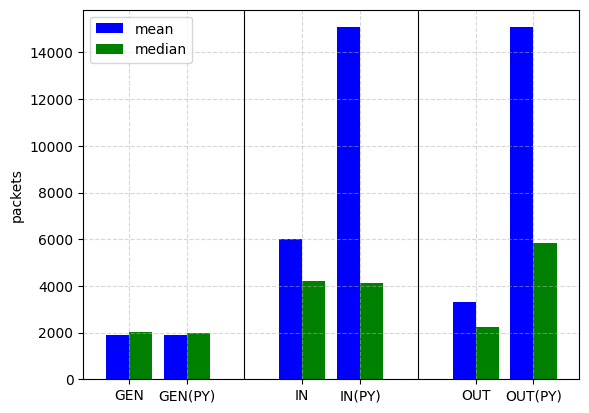

In [195]:
import statistics as st 

mean_col = lambda name : st.mean(result[name].to_list())
median_col = lambda name : st.median(result[name].to_list())


plt.bar(-0.2, mean_col('GEN'),color='b', width=.4)
plt.bar(0.2, median_col('GEN'),color='g', width=.4)
plt.bar(0.8,  mean_col('GEN(PY)'),color='b', width=.4)
plt.bar(1.2,  median_col('GEN(PY)'),color='g', width=.4)

plt.axvline(x=2, color='black', linestyle='-', linewidth=.8)

plt.bar(2.8, mean_col('IN'),color='b', width=.4)
plt.bar(3.2, median_col('IN'),color='g', width=.4)
plt.bar(3.8,  mean_col('IN(PY)'),color='b', width=.4)
plt.bar(4.2,  median_col('IN(PY)'),color='g', width=.4)

plt.axvline(x=5, color='black', linestyle='-', linewidth=.8)

plt.bar(5.8, mean_col('OUT'),color='b', width=.4)
plt.bar(6.2, median_col('OUT'),color='g', width=.4)
plt.bar(6.8,  mean_col('OUT(PY)'),color='b', width=.4, label='mean')
plt.bar(7.2,  median_col('OUT(PY)'),color='g', width=.4, label='median')

plt.legend()

plt.ylabel('packets')

plt.xticks([0,1,3,4,6,7], ['GEN', 'GEN(PY)', 'IN', 'IN(PY)', 'OUT', 'OUT(PY)'])
plt.grid(alpha=.5, linestyle='--')

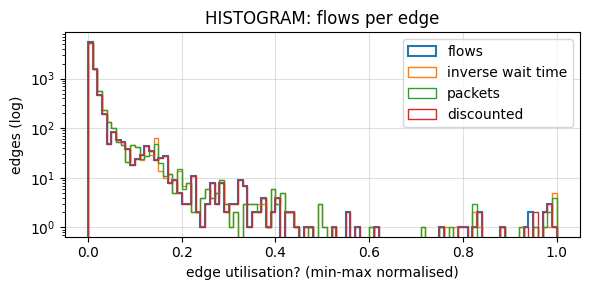

In [198]:
def normalise(edge_dict):
    values = np.array([value for value in edge_dict.values()])
    return (values - np.min(values)) / (np.max(values) - np.min(values))

scaled_flows = normalise(flows_over_edge)
scaled_inverse_mean_wait_times = normalise(total_inverse_packet_wait_times)
scaled_packets = normalise(total_packets)
scaled_disc = normalise(flows_over_edge_discounted)

plt.figure(figsize=(6,3))

plt.hist(scaled_flows, bins=100, histtype='step', linewidth=1.5, label='flows')
plt.hist(scaled_inverse_mean_wait_times, bins=100, histtype='step', linewidth=1, label='inverse wait time')
plt.hist(scaled_packets, bins=100, histtype='step', linewidth=1, label='packets')
plt.hist(scaled_disc, bins=100, histtype='step', linewidth=1, label='discounted')

plt.yscale('log')
plt.grid(alpha=.4)
plt.xlabel('edge utilisation? (min-max normalised)')
plt.ylabel('edges (log)')
plt.title('HISTOGRAM: flows per edge')
plt.legend()
plt.tight_layout()
plt.show()

THESE CALCULATE ALL EDGES BY CREATING A GRAPH AND ADD THE CALCULATED UTILISATION TO EACH EDGE
- might not be useful since for metis we used node weights which we can easily get for all nodes without building the graph

In [ ]:
def edge_information_directed(edge_utilisation, all_switches):
    G = nx.DiGraph()
    
    # Create a graph of the network and extract all edges
    for id, current_switch in all_switches.items():
        conns_iterator = [route.dest_id for route in current_switch.routes if route.dest_id in subnet_ids] # ignore 4280 that is referenced by 1 switch (4280 has no other connections so this does not break the subnet)
        for c in set(conns_iterator):
            G.add_edge(id, c)

    all_edges = dict.fromkeys(G.edges, 0)

    # Update the edge information to include the utilisation numbers extracted 
    for edge, utilisation in edge_utilisation.items():
        all_edges[edge] = utilisation

    return all_edges, G

edge_info_directed, directed_graph = edge_information_directed(total_packets, switches)


In [ ]:
edge_info_undirected = {}

reverse = lambda x: (x[1], x[0])

for edge, utilisation in edge_info_directed.items():
    if reverse(edge) in edge_info_undirected:
        edge_info_undirected[reverse(edge)] += utilisation
    else:
        edge_info_undirected[edge] = edge_info_directed.get(edge, 0) + utilisation

undirected_graph = directed_graph.to_undirected()

print(len(undirected_graph.edges), len(edge_info_undirected))

11889 11889


In [87]:
def node_information_from_edges(edges, all_switches):
    nodes = dict.fromkeys(all_switches.keys())

    for edge, utilisation in edges.items():
        source, destination = edge[0], edge[1]

        if nodes[source] is None:
            nodes[source] =  dict(pin=0, pout=0)
        
        if nodes[destination] is None:
            nodes[destination] = dict(pin=0, pout=0)

        nodes[source]['pout'] += utilisation
        nodes[destination]['pin'] += utilisation

    return nodes

node_info = node_information_from_edges(edge_info_directed, switches)

In [88]:
undirected_edges_list = [[*edge, utilisation] for edge, utilisation in edge_info_undirected.items()]
undirected_edges_df = pd.DataFrame(undirected_edges_list, columns=['nodeID1','nodeID2', 'utilisation'])
undirected_edges_df.to_csv("partition_info/undirected_edges_packets.csv", index=False)

directed_edges_list = [[*edge, utilisation] for edge, utilisation in edge_info_directed.items()]
directed_edges_df = pd.DataFrame(directed_edges_list, columns=['nodeID1','nodeID2', 'utilisation'])
directed_edges_df.to_csv("partition_info/directed_edges_packets.csv", index=False)


node_info_list = [[node, value['pin'], value['pout']] for node,value in node_info.items()]
node_info_df =  pd.DataFrame(node_info_list, columns=['nodeID','in', 'out'])
node_info_df.to_csv("partition_info/nodes_packets.csv", index=False)